# Data Mining
## Knowledge Extraction through Data Analysis

### This notebook presents some tests on Data Analysis, including Locality Sensitive Hashing (LSH).
#### The topic of this experimentation is duplicate questions detection.

In this experiment we want to determine how many of the questions in the test set exist in the training set.

<u>Note</u>: The dataset is not provided since I was given this dataset as part of an assignment and I do not know whether I am allowed to share it.

#### This notebook uses Python version 3.6 or newer.

Let's start by installing the necessary libraries and toolkits using both Conda and Pip.

In [1]:
import sys


if int(sys.version[0]) < 3 or int(sys.version[2]) < 6:
    # Check Python versions
    assert("Python version 3.6 or newer is required")
else:
    # Install the required conda packages
    !conda install --yes --prefix {sys.prefix} matplotlib nltk pandas scikit-learn
    !conda install --yes --prefix {sys.prefix} -c conda-forge wordcloud
    !{sys.executable} -m pip install --upgrade datasketch[scipy]

Solving environment: done

# All requested packages already installed.

Solving environment: done

## Package Plan ##

  environment location: /mnt/disk/miniconda3/envs/bda

  added / updated specs:
    - wordcloud


The following packages will be UPDATED:

  ca-certificates    pkgs/main::ca-certificates-2020.10.14~ --> conda-forge::ca-certificates-2020.12.5-ha878542_0
  certifi            pkgs/main::certifi-2020.11.8-py38h06a~ --> conda-forge::certifi-2020.12.5-py38h578d9bd_0

The following packages will be SUPERSEDED by a higher-priority channel:

  openssl              pkgs/main::openssl-1.1.1h-h7b6447c_0 --> conda-forge::openssl-1.1.1h-h516909a_0


Preparing transaction: done
Verifying transaction: done
Executing transaction: done


We continue by importing the necessary libraries and toolkits.

In [2]:
import math
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import re
from datasketch import MinHash, MinHashLSH
from datetime import date, datetime
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from scipy.sparse import csr_matrix, vstack
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


%matplotlib inline


nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Data Exploration

Let's load the training dataset into a Pandas Dataframe and take perform some data exploration.

In [3]:
df_train = pd.read_csv('./datasets/q2a/corpusTrain.csv', sep=',', index_col=0, dtype=str)
df_train.head()

,Content
Id,
0,How many people are going towards using phones...
1,What audio format should I use for getting aud...
2,What is the corporate culture like at Edwards ...
3,What is the best barbecue in Kansas City?\n
4,"""Can I combine the output of two bolts to one ..."


Let's check the number records in this dataset.

In [4]:
df_train.shape[0]

531990

Now, let's check for NULL values.

In [5]:
df_train.isnull().sum()

Content    0
dtype: int64

We can see that 0 out of 531990 records in the training set contain NULL values, which means all questions contain text.

Let's take a look at our questions, using a WordCloud.

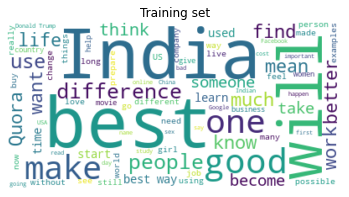

In [6]:
# Extract questions from DataFrame as a string.
text = ''.join(df_train['Content'].to_list())

# Create a Word Cloud
wordcloud = WordCloud(stopwords=set(STOPWORDS), max_words=80, background_color="white", normalize_plurals=False)
image = wordcloud.generate_from_text(text)

# Plot wordcloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Training set")
plt.show()

Now, we will perform the same steps for the test set.

In [7]:
df_test = pd.read_csv('./datasets/q2a/corpusTest.csv', sep=',', index_col=0, dtype=str)
df_test.head()

,Content
Id,
0,How do I get good marks in college?\n
1,Can an android app use SMS only to communicate...
2,What small detail from an Indian movie do you ...
3,Why can not Hindu women be the soldier of Hind...
4,How would you write out twelve lakh twelve tho...


In [8]:
df_test.shape[0]

5374

In [9]:
df_test.isnull().sum()

Content    0
dtype: int64

We can see that 0 out of 5374 records in the test set contain NULL values, which means all questions contain text.

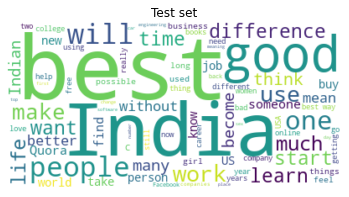

In [10]:
# Extract questions from DataFrame as a string.
text = ''.join(df_test['Content'].to_list())

# Create a Word Cloud
wordcloud = WordCloud(stopwords=set(STOPWORDS), max_words=80, background_color="white", normalize_plurals=False)
image = wordcloud.generate_from_text(text)

# Plot wordcloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Test set")
plt.show()

From the word clouds we notice a grear similarity between words in questions in training set and test set.

## Data Preprocessing

Before we proceed with the comparisons, we should perform some <b>text preprocessing</b> on both datasets, to achieve better results.<br/>
This preprocessing includes:
* Removing URLs
* Removing English stop words
* Removing non-alphanumeric characters
* Stemming words
* Replacing empty strings, after preprocessing, with the "emptystring" string

In [11]:
# Clean text
def text_preprocess(text, stopwords, stemmer):
    # Remove hyperlinks
    text = re.sub(r'(https?:\/\/)?([\da-z\.-]+)\.([a-z\.]{2,6})([\/\w \.-])', '', text)
    # Remove non-alphanumeric characters
    text = re.sub('[\W_]+', ' ', text)
    # Remove non-alphabet characters
#     text = re.sub('[^a-zA-Z]+', ' ', text)
    # Tokenize tweets
    tokens = word_tokenize(text)
    # Stem words that are not stopwords
    tokens = [stemmer.stem(token) for token in tokens if token not in stopwords]
    if not tokens:
        tokens = ['emptystring']

    return ' '.join(tokens)



stemmer = SnowballStemmer('english')

df_train['processed_text'] = df_train['Content'].apply(text_preprocess, args=(stopwords.words('english'), stemmer))
df_test['processed_text'] = df_test['Content'].apply(text_preprocess, args=(stopwords.words('english'), stemmer))

Let's take a look at what we achieved with this preprocessing.

In [12]:
df_train.head()

,Content,processed_text
Id,,
0,How many people are going towards using phones...,how mani peopl go toward use phone search loca...
1,What audio format should I use for getting aud...,what audio format i use get audio track live p...
2,What is the corporate culture like at Edwards ...,what corpor cultur like edward lifesci how cul...
3,What is the best barbecue in Kansas City?\n,what best barbecu kansa citi
4,"""Can I combine the output of two bolts to one ...",can i combin output two bolt one bolt apach st...


In [13]:
df_test.head()

,Content,processed_text
Id,,
0,How do I get good marks in college?\n,how i get good mark colleg
1,Can an android app use SMS only to communicate...,can android app use sms communic question inte...
2,What small detail from an Indian movie do you ...,what small detail indian movi love
3,Why can not Hindu women be the soldier of Hind...,whi hindu women soldier hinduism whi give birt...
4,How would you write out twelve lakh twelve tho...,how would write twelv lakh twelv thousand twel...


## Data Preparation

We know that vectorized operations significantly increase the efficiency and the execution speed of arithmetic operations.<br/>
For this reason, we are going to perform as many vectorized operations as possible, to speed-up the execution.<br/>
Otherwise, we would have to wait days before we could get any result.

Now, we should convert the questions to <b>binary word vectors</b>, in order to be able to compare them efficiently with each other.

In [14]:
vectorizer = CountVectorizer(stop_words=stopwords.words('english'), token_pattern=r'\w{3,}', ngram_range=(1, 3), binary=True)

vectorizer.fit(df_train['processed_text'])

train_vectors = vectorizer.transform(df_train['processed_text'])
test_vectors = vectorizer.transform(df_test['processed_text'])

## Comparisons

Now, we should define the parameters we are going to use across all experiments.

* Similarity threshold 80% - this means that two questions are considered duplicate if their similarity score is higher than 80%.
* Split factor 10% - this means we compare the test set against 10% of our training set in every epoch, leading to the need of 10 epochs to complete the comparisons.

In [15]:
sim_thresh=0.8
split_factor=0.1

### Cosine similarity - One VS All

In our first experiment, we are going to perform an One-VS-All comparison, using cosine similarity as the similarity metric.

In [16]:
# Cosine similarity - one VS all


# Search for duplicates
def query(train_vectors, test_vectors, sim_thresh=0, split_factor=1.0):
    """
    train_vectors: questions in training set (in vector form)
    test_vectors: questions in test set (in vector form)
    sim_thresh: similarity threshold above which questions are considered similar
    split_factor: split training vectors into chunks, to avoid memory overflow
    """
    
    n = int(math.floor(1.0/split_factor))
    m = int(math.floor(split_factor * train_vectors.shape[0]))
    
    duplicates = np.array([])
    
    print("Searching for duplicates using cosine similarity...")
    
    start_time = datetime.now()
    
    for i in range(n):
        arr = np.where(np.any(cosine_similarity(test_vectors, train_vectors[i*m:i*m+m]) > sim_thresh, axis=1))
        duplicates = np.union1d(duplicates, arr)
    arr = np.where(np.any(cosine_similarity(test_vectors, train_vectors[i*m:i*m+m]) > sim_thresh, axis=1))
    duplicates = np.union1d(duplicates, arr)
    
    end_time = datetime.now()
    
    duration = datetime.combine(date.min, end_time.time()) - datetime.combine(date.min, start_time.time())
    duration = duration.total_seconds()
    
    print("Search complete!")
    
    return duplicates.size, duration



print("-" * 40)

duplicate_pairs, query_time = query(train_vectors=train_vectors, test_vectors=test_vectors, sim_thresh=sim_thresh, split_factor=split_factor)

print(f"Time to complete comparisons: {query_time} seconds")
print(f"Total time: {query_time}")
print(f"Duplicates: {duplicate_pairs}")
print("-" * 40)

----------------------------------------
Searching for duplicates using cosine similarity...
Search complete!
Time to complete comparisons: 42.413477 seconds
Total time: 42.413477
Duplicates: 1228
----------------------------------------


### Jaccard similarity - One VS All

In our second experiment, we are going to perform an One-VS-All comparison, using Jaccard similarity as the similarity metric.

In [17]:
# Jaccard similarity - one VS all


def pairwise_jaccard_sparse(csr, idx, sim_thresh=0):
    """Computes the Jaccard distance between the rows of `csr`,
    returning rows from idx and afterwards whose similarity is
    higher than the cut-off distance `sim_thresh`.
    """
    assert(0 < sim_thresh < 1)
    
    csr_rownnz = csr.getnnz(axis=1)
    intrsct = csr.dot(csr.T)
    
    nnz_i = np.repeat(csr_rownnz, intrsct.getnnz(axis=1))
    unions = nnz_i + csr_rownnz[intrsct.indices] - intrsct.data
    sims = intrsct.data / unions.astype('float64')
    
    mask = (sims > sim_thresh) & (sims < 1.0)
    data = sims[mask]
    indices = intrsct.indices[mask]

    rownnz = np.add.reduceat(mask, intrsct.indptr[:-1])
    indptr = np.r_[0, np.cumsum(rownnz)]
    
    out = csr_matrix((data, indices, indptr), intrsct.shape)
    
    return out[idx:, :idx].nonzero()[0]


# Search for duplicates
def query(train_vectors, test_vectors, sim_thresh=0, split_factor=1.0):
    """
    train_vectors: questions in training set (in vector form)
    test_vectors: questions in test set (in vector form)
    sim_thresh: similarity threshold above which questions are considered similar
    split_factor: split training vectors into chunks, to avoid memory overflow
    """
    
    n = int(math.floor(1.0/split_factor))
    m = int(math.floor(split_factor * train_vectors.shape[0]))
    
    duplicates = np.array([])
    
    print("Searching for duplicates using Jaccard similarity...")
    
    start_time = datetime.now()
    
    for i in range(n):
        csr = vstack([train_vectors[i*m:i*m+m], test_vectors])
        arr = pairwise_jaccard_sparse(csr, m, sim_thresh)
        duplicates = np.union1d(duplicates, arr)
    csr = vstack([train_vectors[i*m:], test_vectors])
    arr = pairwise_jaccard_sparse(csr, m, sim_thresh)
    duplicates = np.union1d(duplicates, arr)
    
    end_time = datetime.now()
        
    duration = datetime.combine(date.min, end_time.time()) - datetime.combine(date.min, start_time.time())
    duration = duration.total_seconds()
    
    print("Search complete!")
    
    return duplicates.size, duration



print("-" * 40)

duplicate_pairs, query_time = query(train_vectors=train_vectors, test_vectors=test_vectors, sim_thresh=sim_thresh, split_factor=split_factor)

print(f"Time to complete comparisons: {query_time} seconds")
print(f"Total time: {query_time}")
print(f"Duplicates: {duplicate_pairs}")
print("-" * 40)

----------------------------------------
Searching for duplicates using Jaccard similarity...
Search complete!
Time to complete comparisons: 93.877915 seconds
Total time: 93.877915
Duplicates: 156
----------------------------------------


Clearly, the number of duplicates using cosine similarity is significantly higher than the number of duplicates using Jaccard similarity.

### Cosine similarity - LSH

Another way of performing the comparisons is utilizing Locality-Sensitive Hashing (LSH).

In the following experiment, we are going to use LSH through SimHash for cosine similarity with random binary projection.

In [18]:
# Cosine similarity through LSH indexing
# Custom personal implementation utilizing MinHash and Random Binary Projection


class LSH_cosine:
    def __init__(self, hash_size, dimensions):
        self.k = hash_size
        self.dim = dimensions
        self.ref_planes = csr_matrix(np.random.randn(self.k, self.dim))
        self.hash_table = dict()
    
    def index(self, data):
        """
        LSH signature generation using random projection
        Returns the signature bits for a number of data points.
        The signature bits of the points are different
        only for the plane that divides the two points.
        """
        keys = self.__hash(data)
        
        for i in range(data.shape[0]):
            self.hash_table.setdefault(keys[i].tobytes(), []).append(data[i])
    
    def query(self, data, threshold=0):
        keys = self.__hash(data)
        
        neighbors = []
        
        for i in range(data.shape[0]):
            candidates = []
            candidates.extend(self.hash_table.get(keys[i].tobytes()))
            candidates_matrix = vstack(candidates)
            similarities = cosine_similarity(candidates_matrix, data[i]) > threshold
            neighbors.append(candidates_matrix[similarities[:,0]])
        
        return neighbors
    
    def __hash(self, data):
        projs = data @ self.ref_planes.T
        signs = (projs > 0)
        keys = np.packbits(signs.toarray(), axis=-1)
        
        return keys

# Build LSH index using MinHash
def build_index(vectors, k=64, train_percentage=1.0):
    
    dim = train_vectors.shape[1]
    
    # Create LSH index
    lsh_index = LSH_cosine(hash_size=k, dimensions=dim)
    
    print("Indexing vectors using k=" + str(k) + "...")
    
    start_time = datetime.now()
    
    # Index train vectors
    lsh_index.index(vectors)
    
    end_time = datetime.now()
    
    duration = datetime.combine(date.min, end_time.time()) - datetime.combine(date.min, start_time.time())
    duration = duration.total_seconds()
    
    print("Index built!")
    print("Time to build the index: " + str(duration) + " seconds")
    
    return lsh_index, duration


# Search for duplicates
def query(vectors, lsh_index, k, sim_thresh=0):
    
    duplicates = 0
    
    print("Searching for duplicates using k=" + str(k) + "...")
    
    start_time = datetime.now()
    
    results = lsh_index.query(test_vectors, threshold=sim_thresh)
    
    for result in results:
        if result.size:
            duplicates += 1
    
    end_time = datetime.now()
            
    duration = datetime.combine(date.min, end_time.time()) - datetime.combine(date.min, start_time.time())
    duration = duration.total_seconds()
    
    print("Search complete!")
    print("Time to complete the search: " + str(duration) + " seconds")
    
    return duplicates, duration



duplicates = []
index_times = []
query_times = []
k_list = list(range(2,12))

print("Searching for duplicates using LSH, cosine distance and random binary projection")

print("-" * 40)

for k in k_list:

    print("Using k=" + str(k))

    lsh_index, index_time = build_index(vectors=train_vectors, k=k)
    duplicate_pairs, query_time = query(vectors=test_vectors, lsh_index=lsh_index, k=k, sim_thresh=sim_thresh)
    
    index_times.append(index_time)
    query_times.append(query_time)
    duplicates.append(duplicate_pairs)

    print("Total time: " + str(index_time + query_time))
    print("Duplicates: " + str(duplicate_pairs))
    print("-" * 40)

Searching for duplicates using LSH, cosine distance and random binary projection
----------------------------------------
Using k=2
Indexing vectors using k=2...
Index built!
Time to build the index: 60.108792 seconds
Searching for duplicates using k=2...
Search complete!
Time to complete the search: -75157.176143 seconds
Total time: -75097.067351
Duplicates: 1052
----------------------------------------
Using k=3
Indexing vectors using k=3...
Index built!
Time to build the index: 58.538615 seconds
Searching for duplicates using k=3...
Search complete!
Time to complete the search: 6134.085077 seconds
Total time: 6192.623692
Duplicates: 998
----------------------------------------
Using k=4
Indexing vectors using k=4...
Index built!
Time to build the index: 61.013743 seconds
Searching for duplicates using k=4...
Search complete!
Time to complete the search: 3267.33272 seconds
Total time: 3328.346463
Duplicates: 927
----------------------------------------
Using k=5
Indexing vectors usin

Let's plot the results.

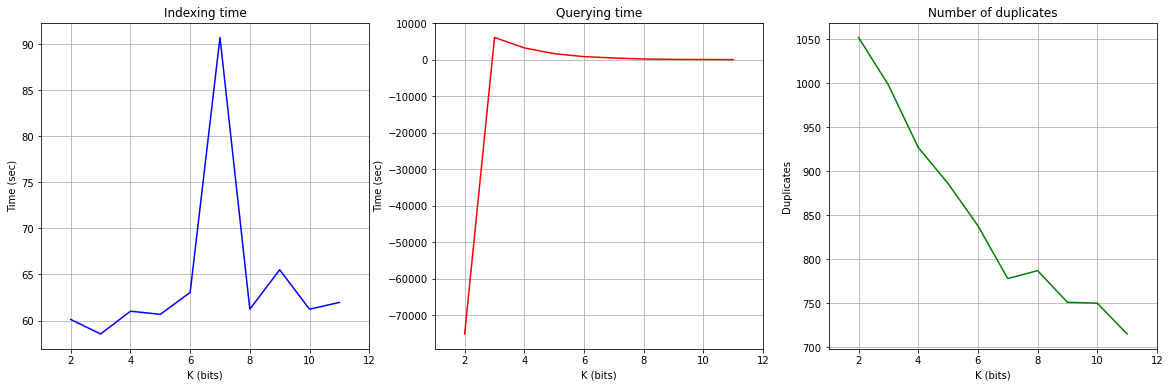

In [19]:
fig = plt.figure(figsize=(20, 6))

plt.subplot(1,3,1)
plt.plot(k_list, index_times, color='b')
plt.xlim(1,k_list[-1]+1)
plt.grid(True)
plt.xlabel('K (bits)')
plt.ylabel('Time (sec)')
plt.title("Indexing time")

plt.subplot(1,3,2)
plt.plot(k_list, query_times, color='r')
plt.xlim(1,k_list[-1]+1)
plt.grid(True)
plt.xlabel('K (bits)')
plt.ylabel('Time (sec)')
plt.title("Querying time")

plt.subplot(1,3,3)
plt.plot(k_list, duplicates, color='g')
plt.xlim(1,k_list[-1]+1)
plt.grid(True)
plt.xlabel('K (bits)')
plt.ylabel('Duplicates')
plt.title("Number of duplicates")

plt.show()

We can see that while the indexing time ranges between 58 and 62 seconds for every value of K, the querying time drops significantly as the value of K increases.

Furthermore, the number of duplicates drops almost linearly as the value of K increases, as was expected, since more projection bits give a better representation of the projected vector.

Finally, compared to the One-VS-All approach, we notice that the number of duplicates is lower when we use LSH when $\text{K}\geq 2$, and the reason this happens is because of the false negatives that are unavoidable when using LSH.

### Jaccard similarity - LSH

In the following experiment, we are going to use LSH through MinHash for Jaccard similarity.

In [20]:
# Jaccard similarity through LSH indexing
# Implementation based on https://github.com/ekzhu/datasketch



# Hash a vector using MinHash
def hash_vector(vector, num_perm):
    
    minhash = MinHash(num_perm=num_perm)
    
    for coef in vector.todense():
        minhash.update(coef)
    
    return minhash

# Build LSH index using MinHash
def build_index(vectors, num_perm, sim_thresh=0.8, train_percentage=1.0):
    
    lsh_index = MinHashLSH(sim_thresh, num_perm=num_perm)
    
    print("Building index using " + str(num_perm) + " permutation functions...")
    
    start_time = datetime.now()
    
    for index, vector in enumerate(vectors[:int(vectors.shape[0] * train_percentage)]):
        hashed_vector = hash_vector(vector, num_perm)
        lsh_index.insert(index, hashed_vector)
    
    end_time = datetime.now()
    
    duration = datetime.combine(date.min, end_time.time()) - datetime.combine(date.min, start_time.time())
    duration = duration.total_seconds()
    
    print("Index built!")
    print("Time to build the index: " + str(duration) + " seconds")
    
    return lsh_index, duration

# Search for duplicates
def query(vectors, lsh_index, num_perm):
    
    duplicates = 0
    
    print("Searching for duplicates using " + str(num_perm) + " permutation functions...")
    
    start_time = datetime.now()
    
    for vector in vectors:
        hashed_vector = hash_vector(vector, num_perm)
        result = lsh_index.query(hashed_vector)
        
        if result:
            duplicates += 1
    
    end_time = datetime.now()
            
    duration = datetime.combine(date.min, end_time.time()) - datetime.combine(date.min, start_time.time())
    duration = duration.total_seconds()
    
    print("Search complete!")
    print("Time to complete the search: " + str(duration) + " seconds")
    
    return duplicates, duration



duplicates = []
index_times = []
query_times = []
perm_list = [16 * 2**i for i in range(6)]

print("Searching for duplicates using LSH and Jaccard distance")

print("-" * 40)

for perm in perm_list:

    print(f"Using {perm} permutation functions")
    
    lsh_index, index_time = build_index(vectors=train_vectors, num_perm=perm)
    duplicate_pairs, query_time = query(vectors=test_vectors, lsh_index=lsh_index, num_perm=perm)
    
    index_times.append(index_time)
    query_times.append(query_time)
    duplicates.append(duplicate_pairs)

    print("Total time: " + str(index_time + query_time))
    print("Duplicates: " + str(duplicate_pairs))
    print("-" * 40)

Searching for duplicates using LSH and Jaccard distance
----------------------------------------
Using 16 permutation functions
Building index using 16 permutation functions...
Index built!
Time to build the index: 19413.548502 seconds
Searching for duplicates using 16 permutation functions...
Search complete!
Time to complete the search: 182.626087 seconds
Total time: 19596.174589000002
Duplicates: 575
----------------------------------------
Using 32 permutation functions
Building index using 32 permutation functions...
Index built!
Time to build the index: 18746.600416 seconds
Searching for duplicates using 32 permutation functions...
Search complete!
Time to complete the search: 183.793412 seconds
Total time: 18930.393828
Duplicates: 575
----------------------------------------
Using 64 permutation functions
Building index using 64 permutation functions...
Index built!
Time to build the index: 18919.204313 seconds
Searching for duplicates using 64 permutation functions...
Search co

Let's plot the results.

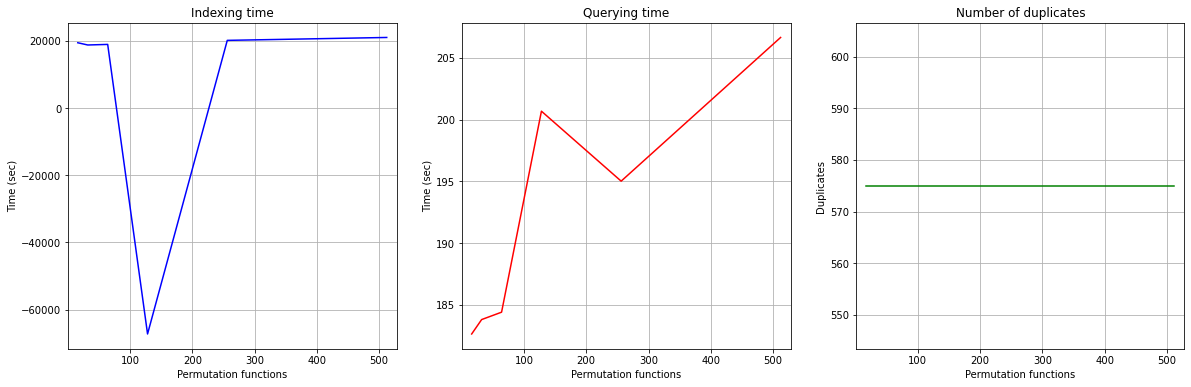

In [25]:
fig = plt.figure(figsize=(20, 6))

plt.subplot(1,3,1)
plt.plot(perm_list, index_times, color='b')
plt.xlim(1,perm_list[-1]+perm_list[0])
plt.grid(True)
plt.xlabel('Permutation functions')
plt.ylabel('Time (sec)')
plt.title("Indexing time")

plt.subplot(1,3,2)
plt.plot(perm_list, query_times, color='r')
plt.xlim(1,perm_list[-1]+perm_list[0])
plt.grid(True)
plt.xlabel('Permutation functions')
plt.ylabel('Time (sec)')
plt.title("Querying time")

plt.subplot(1,3,3)
plt.plot(perm_list, duplicates, color='g')
plt.xlim(1,perm_list[-1]+perm_list[0])
plt.grid(True)
plt.xlabel('Permutation functions')
plt.ylabel('Duplicates')
plt.title("Number of duplicates")

plt.grid(True)
plt.show()

We can see that the indexing time is almost constant regardless of the number of permutation functions, while the querying time slightly increases as the number of permutation functions increases.<br>
Furthermore, the number of duplicates is exactly the same regardless of the number of permutation functions.<br>
Finally, compared to the One-VS-All approach, we notice that the number of duplicates is higher when we use LSH this happens is because of the false positives that are unavoidable when using LSH.